# VLLE @ constant pressure

Following the approach described in Bell et al.: https://doi.org/10.1021/acs.iecr.1c04703, but slightly different because the pressure is fixed rather than the temperature, but the same basic principles hold

for the mixture of nitrogen + ethane, with the default thermodynamic model in teqp, which is the GERG-2008 mixing parameters (no departure function).

Two traces are made, and the intersection is obtained, this gives you the VLLE solution.

rhovec / mol/m^3 | T / K
[4921.97976373    9.6755684 ] 125.14729018874252
[ 6008.68040253 15630.22353351] 125.14729018874252
[18948.39537895  1540.60935171] 125.14729018874252


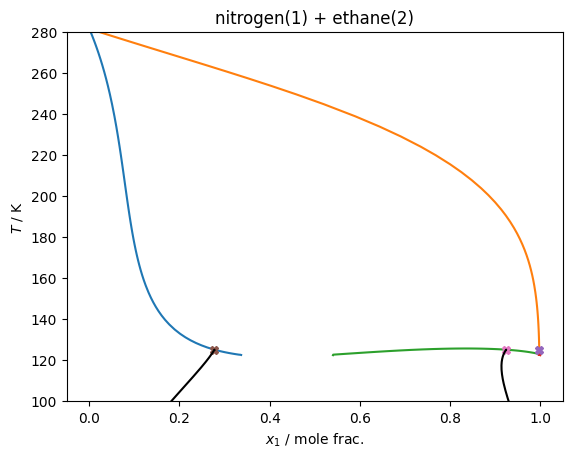

In [1]:
import teqp, numpy as np, matplotlib.pyplot as plt, pandas
import CoolProp.CoolProp as CP 

names = ['Nitrogen', 'Ethane']
model = teqp.build_multifluid_model(names, teqp.get_datapath())
pures = [teqp.build_multifluid_model([name], teqp.get_datapath()) for name in names]
p = 29e5 # Pa

# Trace from both pure fluid endpoints
traces = []
for ipure in [1,0]:
    # Init at the pure fluid endpoint
    anc = pures[ipure].build_ancillaries()
    rhoLpure, rhoVpure = [CP.PropsSI('Dmolar','P',p,'Q',Q,names[ipure]) for Q in [0,1]]
    T = CP.PropsSI('T','P',p,'Q',0,names[ipure])

    rhovecL = np.array([0.0, 0.0])
    rhovecV = np.array([0.0, 0.0])
    rhovecL[ipure] = rhoLpure
    rhovecV[ipure] = rhoVpure
    j = model.trace_VLE_isobar_binary(p, T, rhovecL, rhovecV)
    df = pandas.DataFrame(j)
    plt.plot(df['xL_0 / mole frac.'], df['T / K'])
    plt.plot(df['xV_0 / mole frac.'], df['T / K'])
    traces.append(j)
    
# Do the VLLE solving
for soln in model.find_VLLE_p_binary(traces):
    T = soln['polished'][-1]
    print('rhovec / mol/m^3 | T / K')
    for rhovec in soln['polished'][0:3]:
        rhovec = np.array(rhovec)
        rhotot = sum(rhovec)
        x = rhovec/rhotot
        p = rhotot*model.get_R(x)*T*(1+model.get_Ar01(T, rhotot, x))
        plt.plot(x[0], T, 'X')
        print(rhovec, T)
        
    # And also carry out the LLE trace for the two liquid phases
    opt = teqp.PVLEOptions()
    opt.integration_order = 5
    opt.init_dt = 1e-10
    # Or could be 1 depending on the initial integration direction, do not know the direction 
    # a priori because not starting at a pure fluid endpoint
    for init_dt in [-1]: 
        opt.init_c = init_dt 
        rhovecV, rhovecL1, rhovecL2, T = soln['polished']
        j = model.trace_VLE_isobar_binary(p, T, np.array(rhovecL1), np.array(rhovecL2), opt)
        df = pandas.DataFrame(j)
        plt.plot(df['xL_0 / mole frac.'], df['T / K'], 'k')
        plt.plot(df['xV_0 / mole frac.'], df['T / K'], 'k')

# Plotting niceties
plt.ylim(top=280, bottom=100)
plt.gca().set(xlabel='$x_1$ / mole frac.', ylabel='$T$ / K', title='nitrogen(1) + ethane(2)')
plt.show()